In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tempfile
import requests
import joblib
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import  Embedding, Dense, GRU, Activation
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import mixed_precision
from livelossplot.tf_keras import PlotLossesCallback
np.random.seed(0)
plt.style.use("ggplot")

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
url = "https://raw.githubusercontent.com/seanbenhur/NER/main/data/ner_dataset.csv"
data = pd.read_csv(url, encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [4]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
word2idx_path = "/content/drive/MyDrive/data/NER/word2idx.joblib"
tag2idx_path = "/content/drive/MyDrive/data/NER/tag2idx.joblib"
batch_size=64
epochs=3
#enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [6]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
joblib.dump("word2idx",word2idx_path)
joblib.dump("tag2idx",tag2idx_path)

['/content/drive/MyDrive/data/NER/tag2idx.joblib']

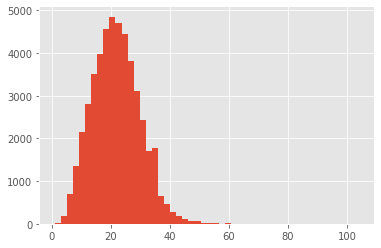

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(GRU(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(num_tags))(model)
out =   Activation('softmax', dtype='float32', name='predictions')(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           91200     
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
_________________________________________________________________
predictions (Activation)     (None, 50, 17)            0         
Total params: 1,853,567
Trainable params: 1,853,567
Non-trainable params: 0
___________________________________________________

In [15]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

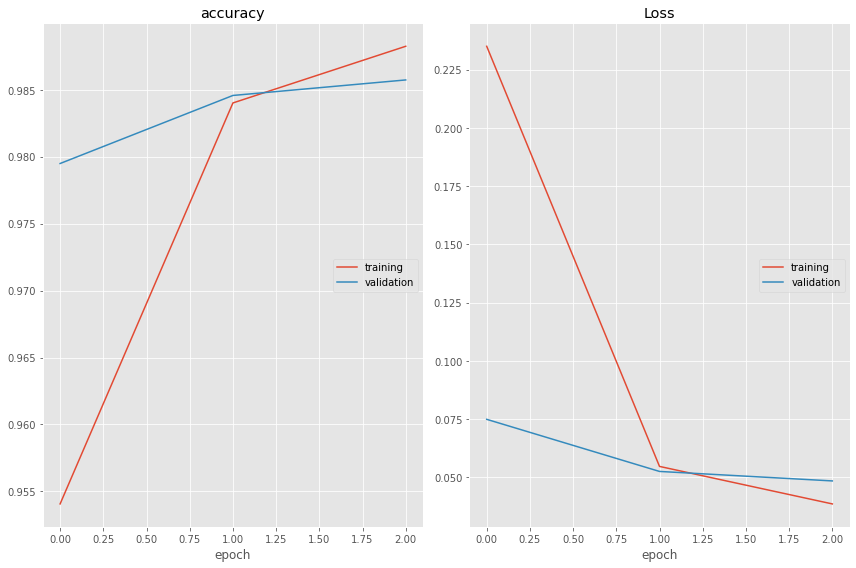

accuracy
	training         	 (min:    0.954, max:    0.988, cur:    0.988)
	validation       	 (min:    0.979, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.039, max:    0.235, cur:    0.039)
	validation       	 (min:    0.048, max:    0.075, cur:    0.048)
CPU times: user 12min 33s, sys: 1min 30s, total: 14min 3s
Wall time: 8min 29s


In [16]:
%%time

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

In [18]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 9s 29ms/step - loss: 0.0484 - accuracy: 0.9857


[0.048425283282995224, 0.9857339262962341]

In [21]:
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 2356
drwxr-xr-x 2 root root    4096 Mar 27 11:13 assets
-rw-r--r-- 1 root root 2404064 Mar 27 11:13 saved_model.pb
drwxr-xr-x 2 root root    4096 Mar 27 11:13 variables


In [23]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 50)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 50, 17)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0327 11:14:34.499265 139654333147008 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/r

In [25]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  37730      0 --:--:-- --:--:-- --:--:-- 37730
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/

In [26]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 59 not upgraded.
Need to get 223 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.4.1 [223 MB]
Fetched 223 MB in 3s (85.9 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.4.1_all.deb ...
Unpacking tensorflow-model-server (2.4.1) ...
Setting up tensorflow-model-server (2.4.1) ...


In [27]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [30]:
!nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=NER_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [31]:
!tail server.log

nohup: ignoring input
2021-03-27 11:17:32.282413: I tensorflow_serving/model_servers/server.cc:88] Building single TensorFlow model file config:  model_name: NER_model model_base_path: $/tmp
2021-03-27 11:17:32.282682: I tensorflow_serving/core/basic_manager.cc:279] Unload all remaining servables in the manager.
Failed to start server. Error: Invalid argument: Expected model NER_model to have an absolute path or URI; got base_path()=$/tmp


In [33]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
U.S.           B-geo	B-geo
officials      O	O
have           O	O
ordered        O	O
a              O	O
recall         O	O
of             O	O
143            O	O
million        O	O
pounds         O	O
of             O	O
beef           O	O
produced       O	O
by             O	O
a              O	O
California     B-org	B-geo
processor      O	O
accused        O	O
of             O	O
violating      O	O
food           O	O
safety         O	O
regulations    O	O
,              O	O
in             O	O
the            O	O
largest        O	O
recall         O	O
in             O	O
U.S.           B-geo	B-geo
history        O	O
.              O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chaba